In [1]:
!pip install stellargraph

     |████████████████████████████████| 440kB 13.3MB/s 


In [2]:
import glob
import itertools
from os.path import join
import pickle
from typing import List
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import stellargraph as sg
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT, GCN
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils import data as data_utils
from tqdm import tqdm

from google.colab import drive

tqdm.pandas()

## Setting seed value

In [3]:
seed_value = 1234

tf.random.set_seed(seed_value)
np.random.seed(seed_value)

## Mount Google Drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading and preparing

In [5]:
data = pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/wiki_pages_lemmas.csv", index_col=0)

In [6]:
print(data.shape)
data.head()

(75792, 4)


,title,text,category,noun_lemmas
0,Mirosław_Miller,Mirosław Miller – Dyrektor Międzynarodowego La...,Chemia,"['mirosława', 'miller', 'dyrektor', 'laborator..."
1,Chimerokształtne,"Chimerokształtne, chimery, przerazy (Chimaerif...",Biologia,"['chimera', 'przeraza', 'chimaeriformes', 'rzą..."
2,(2855)_Bastian,(2855) Bastian (1931 TB2) – planetoida z grupy...,Astronomia,"['bastian', 'tb2', 'planetoida', 'grupa', 'pas..."
3,Cryptocephalus_celtibericus,"""Cryptocephalus celtibericus"" – gatunek chrząs...",Biologia,"['cryptocephalus', 'celtibericus', 'gatunek', ..."
4,Język_maszynowy,"Język maszynowy, kod maszynowy – zestaw rozkaz...",Matematyka,"['język', 'koda', 'zestaw', 'rozkaz', 'proceso..."


In [7]:
data = data.drop_duplicates(subset=['title'])
data = data.reset_index(drop=True)

In [8]:
# noun_lemmas column to list
data['noun_lemmas'] = data['noun_lemmas'].progress_apply(
    lambda row: row[1:-1].replace('\'', '').split(', ')
)

100%|██████████| 75649/75649 [00:01<00:00, 50254.41it/s]


In [9]:
# Encode target labels with value between 0 and n_classes-1
le = LabelEncoder()
le.fit(data['category'].tolist())
labels = le.transform(data['category'].tolist())

data['category'] = labels

data.head()

,title,text,category,noun_lemmas
0,Mirosław_Miller,Mirosław Miller – Dyrektor Międzynarodowego La...,2,"[mirosława, miller, dyrektor, laboratorium, po..."
1,Chimerokształtne,"Chimerokształtne, chimery, przerazy (Chimaerif...",1,"[chimera, przeraza, chimaeriformes, rząd, ryba..."
2,(2855)_Bastian,(2855) Bastian (1931 TB2) – planetoida z grupy...,0,"[bastian, tb2, planetoida, grupa, pas, asteroi..."
3,Cryptocephalus_celtibericus,"""Cryptocephalus celtibericus"" – gatunek chrząs...",1,"[cryptocephalus, celtibericus, gatunek, chrząs..."
4,Język_maszynowy,"Język maszynowy, kod maszynowy – zestaw rozkaz...",5,"[język, koda, zestaw, rozkaz, procesor, zapis,..."


## Top nouns vector

In [10]:
# df = data
# top_k = 1000

# top_nouns = {}
# categories = list(df['category'].unique())

# for cat in categories:
#     noun_lists = df[df['category'] == cat]['noun_lemmas']
#     noun_list = []
#     for l in tqdm(noun_lists):
#         noun_list = noun_list + l
    
#     noun_list = Counter(noun_list).most_common()[0:top_k]
#     noun_list = list(map(lambda x: x[0], noun_list))

#     top_nouns[cat] = noun_list

In [11]:
# with open("/content/drive/Shareddrives/GCN-PROJECT/top_1000_nouns.pickle", "wb") as f:
#   pickle.dump(top_nouns, f)

In [12]:
with open("/content/drive/Shareddrives/GCN-PROJECT/top_1000_nouns.pickle", "rb") as f:
    top_nouns = pickle.load(f)

In [13]:
lookup_dict = dict(enumerate(le.inverse_transform(range(7))))
print(lookup_dict)

{0: 'Astronomia', 1: 'Biologia', 2: 'Chemia', 3: 'Fizyka', 4: 'Informatyka', 5: 'Matematyka', 6: 'Psychologia'}


In [14]:
for key, value in top_nouns.items():
    print(le.inverse_transform([key])[0])
    print(value[0:100], end='\n\n')

Chemia
['rok', 'lek', 'badanie', 'grupa', 'związka', 'działanie', 'chemia', 'kwas', 'uniwersytet', 'to', 'praca', 'wirus', 'nauka', 'czas', 'co', 'dno', 'profesor', 'reakcja', 'substancja', 'dawka', '%', 'nagroda', 'komórka', 'białko', 'proces', 'przypadek', 'receptor', 'związek', 'wydział', 'choroba', 'mechanizm', 'rna', 'członek', 'instytut', 'układ', 'dziedzina', 'cząsteczka', 'postać', 'wynik', 'polska', 'woda', 'metoda', 'stopień', 'of', 'nazwa', 'studium', 'synteza', 'stężenie', 'temperatura', 'stan', 'raz', 'nobel', 'akademia', 'atom', 'człowiek', 'wojna', 'chemik', 'pacjent', 'efekt', 'biochemia', 'właściwość', 'preparat', 'struktura', 'organizm', 'osoba', 'zasada', 'okres', 'zastosowanie', 'funkcja', 'roztwór', 'objaw', 'środek', 'wpływ', 'university', 'miejsce', 'produkt', 'aktywność', 'doktór', 'forma', 'godzina', 'kwasy', 'zaburzenie', 'materiał', 'enzym', 'ilość', 'wzgląd', 'tytuł', 'część', 'produkcja', 'inhibitor', 'życiorys', 'sposób', 'krew', 'wieko', 'dzień', 'zakład'

In [15]:
top_k = 40

top_specific_nouns = {}
for key, value in top_nouns.items():
    specific_nouns = []
    for noun in value:
        specific = True

        for key2, value2 in top_nouns.items():
            if key != key2:
                if noun in value2:
                    specific = False

        if specific:
            specific_nouns.append(noun)

        top_specific_nouns[key] = specific_nouns[:top_k]

In [16]:
with open("/content/drive/Shareddrives/GCN-PROJECT/top_40_specific_nouns.pickle", "wb") as f:
  pickle.dump(top_specific_nouns, f)

In [17]:
for key, value in top_specific_nouns.items():
    print(le.inverse_transform([key])[0])
    print(value, end='\n\n')

Chemia
['rna', 'biochemia', 'grypa', 'biochemik', 'amfetamina', 'szczepionka', 'dopamina', 'rak', 'nukleotyd', 'osocze', 'mrna', 'mocz', 'dawkowanie', 'sars', 'replikacja', 'witamina', 'polimeraza', 'chlorek', 'amina', 'zakażenie', 'antybiotyk', 'mg', 'wskazanie', 'barwnik', 'ph', 'żywność', 'pompa', 'niewydolność', 'chemical', 'kolba', 'cov', 'nerki', 'półtrwanie', 'biegunka', 'nudność', 'toksyczność', 'noradrenalina', 'izomer', 'enancjomer', 'chlor']

Biologia
['samiec', 'lasa', 'kość', 'jajo', 'gniazdo', 'podgatunek', 'pokrywa', 'siedlisko', 'chrząszcz', 'morfologia', 'okaz', 'podrodzina', 'las', 'systematyk', 'takson', 'index', 'fungorum', 'ząb', 'samka', 'azja', 'owocnik', 'grzbiet', 'czaszka', 'ameryka', 'liczebność', 'dziób', 'odnóże', 'ekologia', 'pożywienie', 'spód', 'larwa', 'dinozaur', 'nazewnictwo', 'wierzch', 'płetwa', 'zarodnik', 'pióro', 'holotyp', 'czułek', 'taksonomia']

Astronomia
['planetoida', 'słońca', 'asteroida', 'galaktyka', 'gwiazdozbiór', 'ngc', 'obserwatorium

In [18]:
top_k = 20

top_specific_nouns = {}
for key, value in top_nouns.items():
    specific_nouns = []
    for noun in value:
        specific = True

        for key2, value2 in top_nouns.items():
            if key != key2:
                if noun in value2:
                    specific = False

        if specific:
            specific_nouns.append(noun)

        top_specific_nouns[key] = specific_nouns[:top_k]

In [19]:
with open("/content/drive/Shareddrives/GCN-PROJECT/top_20_specific_nouns.pickle", "wb") as f:
  pickle.dump(top_specific_nouns, f)

In [20]:
for key, value in top_specific_nouns.items():
    print(le.inverse_transform([key])[0])
    print(value, end='\n\n')

Chemia
['rna', 'biochemia', 'grypa', 'biochemik', 'amfetamina', 'szczepionka', 'dopamina', 'rak', 'nukleotyd', 'osocze', 'mrna', 'mocz', 'dawkowanie', 'sars', 'replikacja', 'witamina', 'polimeraza', 'chlorek', 'amina', 'zakażenie']

Biologia
['samiec', 'lasa', 'kość', 'jajo', 'gniazdo', 'podgatunek', 'pokrywa', 'siedlisko', 'chrząszcz', 'morfologia', 'okaz', 'podrodzina', 'las', 'systematyk', 'takson', 'index', 'fungorum', 'ząb', 'samka', 'azja']

Astronomia
['planetoida', 'słońca', 'asteroida', 'galaktyka', 'gwiazdozbiór', 'ngc', 'obserwatorium', 'kometa', 'księżyc', 'pgc', 'krater', 'teleskop', 'herschel', 'mars', 'jowisz', 'ugc', 'meteoryt', 'observatory', 'olbrzym', 'apollo']

Matematyka
['algebra', 'przekształcenie', 'podzbiór', 'logika', 'podgrupa', 'rachunek', 'banach', 'aksjomat', 'kwadrat', 'youtube', 'blog', 'topologia', 'całka', 'tv', 'formuła', 'mnożenie', 'euler', 'rozmaitość', 'witryna', 'html']

Fizyka
['reaktor', 'lampa', 'elektroda', 'wiązka', 'polaryzacja', 'elektrote

In [21]:
def get_vector(text):
    vector = []
    for key, value in top_specific_nouns.items():
        for word in value:
            if word in text:
                vector.append(1)
            else:
                vector.append(0)
    
    return np.array(vector)

In [22]:
data['doc_vec'] = data['noun_lemmas'].progress_apply(get_vector)

100%|██████████| 75649/75649 [00:10<00:00, 6909.39it/s]


In [23]:
data.head()

,title,text,category,noun_lemmas,doc_vec
0,Mirosław_Miller,Mirosław Miller – Dyrektor Międzynarodowego La...,2,"[mirosława, miller, dyrektor, laboratorium, po...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Chimerokształtne,"Chimerokształtne, chimery, przerazy (Chimaerif...",1,"[chimera, przeraza, chimaeriformes, rząd, ryba...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,(2855)_Bastian,(2855) Bastian (1931 TB2) – planetoida z grupy...,0,"[bastian, tb2, planetoida, grupa, pas, asteroi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cryptocephalus_celtibericus,"""Cryptocephalus celtibericus"" – gatunek chrząs...",1,"[cryptocephalus, celtibericus, gatunek, chrząs...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Język_maszynowy,"Język maszynowy, kod maszynowy – zestaw rozkaz...",5,"[język, koda, zestaw, rozkaz, procesor, zapis,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [24]:
data.iloc[2]['doc_vec']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
len(data.iloc[2]['doc_vec'])

140

## Helper functions

In [26]:
def conf_matrix(y_true, y_pred):
    labels = tf.unique(y_true)[0].numpy()
    labels.sort()

    con_mat = confusion_matrix(y_true, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    df_cm = pd.DataFrame(con_mat_norm,
                        index = labels, 
                        columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    plt.title("Confusion matrix")
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

## NN Model

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [28]:
model.compile(optimizer=optimizers.Adam(lr=0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [29]:
X = data['doc_vec']
y = data['category']

In [30]:
# split X, y to train and test_val
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=seed_value
)
# split test_val to test and val
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, stratify=y_test_val, random_state=seed_value
)
# 0.5 x 0.3 = 0.15

In [31]:
print(f'Train: {len(y_train)}')
print(f'Test: {len(y_test)}')
print(f'Val: {len(y_val)}')

Train: 52954
Test: 11347
Val: 11348


In [32]:
history = model.fit(
    tf.convert_to_tensor(np.stack(X_train)),
    y_train,
    epochs=200,
    validation_data=(tf.convert_to_tensor(np.stack(X_val)), y_val)
)

Epoch 1/200
1655/1655 [==============================] - 6s 3ms/step - loss: 0.8006 - accuracy: 0.7246 - val_loss: 0.7006 - val_accuracy: 0.7544
Epoch 2/200
1655/1655 [==============================] - 4s 2ms/step - loss: 0.6943 - accuracy: 0.7559 - val_loss: 0.6889 - val_accuracy: 0.7577
Epoch 3/200
1655/1655 [==============================] - 4s 2ms/step - loss: 0.6721 - accuracy: 0.7640 - val_loss: 0.6969 - val_accuracy: 0.7539
Epoch 4/200
1655/1655 [==============================] - 4s 2ms/step - loss: 0.6772 - accuracy: 0.7608 - val_loss: 0.6886 - val_accuracy: 0.7574
Epoch 5/200
1655/1655 [==============================] - 4s 2ms/step - loss: 0.6743 - accuracy: 0.7624 - val_loss: 0.6991 - val_accuracy: 0.7543
Epoch 6/200
1655/1655 [==============================] - 4s 3ms/step - loss: 0.6619 - accuracy: 0.7655 - val_loss: 0.6995 - val_accuracy: 0.7552
Epoch 7/200
1655/1655 [==============================] - 4s 3ms/step - loss: 0.6612 - accuracy: 0.7646 - val_loss: 0.7087 - val_ac

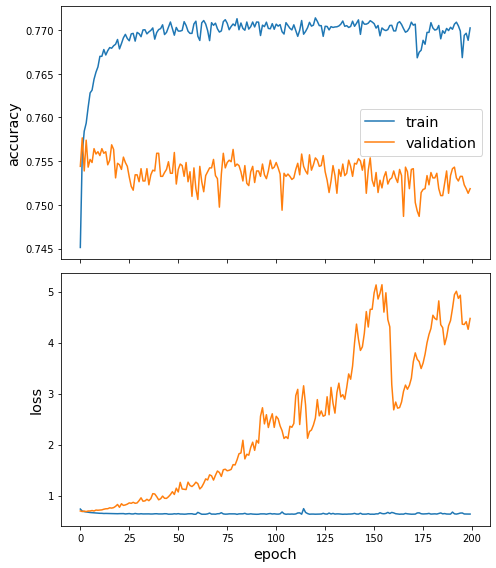

In [33]:
sg.utils.plot_history(history)

In [34]:
y_pred = model.predict(tf.convert_to_tensor(np.stack(X_test)))
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Fizyka',
       'Biologia'], dtype='<U11')

In [35]:
y_test = np.array(y_test)
y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [36]:
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_base_y_pred.pickle", "wb") as f:
  pickle.dump(y_pred, f)
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_base_y_true.pickle", "wb") as f:
  pickle.dump(y_test, f)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.98      0.96      0.97      3832
    Biologia       0.60      0.98      0.74      3522
      Chemia       0.71      0.23      0.35       416
      Fizyka       0.71      0.22      0.34       768
 Informatyka       0.73      0.39      0.51       738
  Matematyka       0.73      0.32      0.45      1211
 Psychologia       0.80      0.51      0.62       860

    accuracy                           0.75     11347
   macro avg       0.75      0.52      0.57     11347
weighted avg       0.78      0.75      0.72     11347



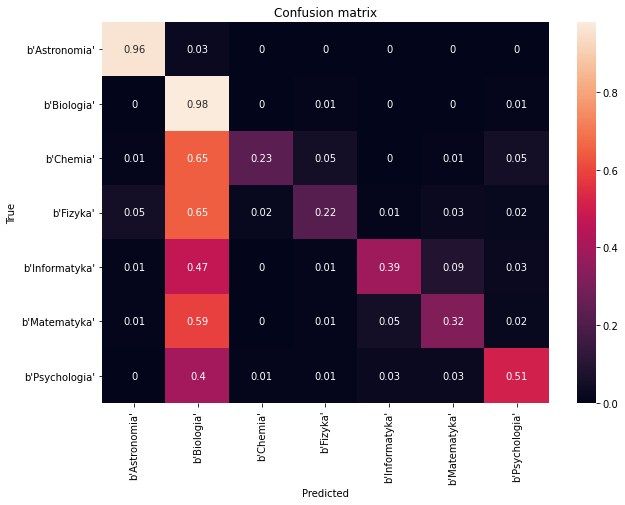

In [38]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)

## GNN Models

### Data Preparation

In [39]:
data_vec = data
node_data = data_vec[['title', 'doc_vec', 'category']]

features_columns = ['x'+str(i+1) for i in range(node_data.iloc[0]['doc_vec'].shape[0])]

node_data[features_columns] = pd.DataFrame(node_data['doc_vec'].tolist(), index=node_data.index)
node_data = node_data.drop_duplicates(subset=['title'])
node_data = node_data.set_index('title', drop=True)

node_subjects = node_data['category']
node_data = node_data.drop(columns=['doc_vec', 'category'])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [40]:
print(node_data.shape)
node_data.head()

(75649, 140)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mirosław_Miller,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chimerokształtne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
(2855)_Bastian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cryptocephalus_celtibericus,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Język_maszynowy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
edges = pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/annotations.csv", header=None)
edges.columns = ['source', 'target']

nodes_set = set(node_data.index)
edges = edges[
    (edges['source'].isin(nodes_set)) &
    (edges['target'].isin(nodes_set))
]

In [42]:
print(edges.shape)
edges.head()

(347655, 2)


,source,target
0,AWK,Język_programowania
2,AWK,System_operacyjny
3,AWK,Unix
4,AWK,Tablica_asocjacyjna
6,AWK,Wyrażenie_regularne


### StellarGraph

In [43]:
stellar_graph = StellarGraph(
    {'article': node_data},
    {'annotation': edges}
)

In [44]:
print(stellar_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 75649, Edges: 347655

 Node types:
  article: [75649]
    Features: float32 vector, length 140
    Edge types: article-annotation->article

 Edge types:
    article-annotation->article: [347655]
        Weights: all 1 (default)
        Features: none


In [45]:
print(set(node_subjects))
print(len(node_subjects))

{0, 1, 2, 3, 4, 5, 6}
75649


### Data preparation

In [46]:
# split node_subjects to train and test_val
train_subjects, test_val_subjects = train_test_split(
    node_subjects, test_size=0.3, stratify=node_subjects, random_state=seed_value
)
# split test_val_subjects to test_subjects and val_subjects
test_subjects, val_subjects = train_test_split(
    test_val_subjects, test_size=0.5, stratify=test_val_subjects, random_state=seed_value
)
# 0.5 x 0.3 = 0.15

In [47]:
print(f'Train: {len(train_subjects)}')
print(f'Test: {len(test_subjects)}')
print(f'Val: {len(val_subjects)}')

Train: 52954
Test: 11347
Val: 11348


In [48]:
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)
val_targets = target_encoding.transform(val_subjects)

### GAT

In [49]:
generator = FullBatchNodeGenerator(stellar_graph, method="gat")

train_gen = generator.flow(train_subjects.index, train_targets)
test_gen = generator.flow(test_subjects.index, test_targets)
val_gen = generator.flow(val_subjects.index, val_targets)

In [50]:
# gat = GAT(
#     layer_sizes=[128, train_targets.shape[1]],
#     activations=["elu", "softmax"],
#     attn_heads=8,
#     generator=generator,
#     in_dropout=0.5,
#     attn_dropout=0.5,
#     normalize=None,
# )

gat = GAT(
    layer_sizes=[128, 128],
    activations=["elu", "elu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [51]:
x_inp, x_out = gat.in_out_tensors()

dense = tf.keras.layers.Dense(units=64, activation="relu")(x_out)
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(dense)

In [52]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [53]:
# if not os.path.isdir("logs"):
#     os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
# mc_callback = ModelCheckpoint(
#     "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
# )

In [54]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback, mc_callback],
    # callbacks=[es_callback],
)

Epoch 1/200
1/1 - 5s - loss: 1.9157 - acc: 0.1829 - val_loss: 1.1841 - val_acc: 0.6750
Epoch 2/200
1/1 - 2s - loss: 1.1925 - acc: 0.6420 - val_loss: 0.8558 - val_acc: 0.7376
Epoch 3/200
1/1 - 2s - loss: 0.8902 - acc: 0.7148 - val_loss: 0.7121 - val_acc: 0.7569
Epoch 4/200
1/1 - 2s - loss: 0.7416 - acc: 0.7433 - val_loss: 0.6394 - val_acc: 0.7804
Epoch 5/200
1/1 - 2s - loss: 0.6898 - acc: 0.7651 - val_loss: 0.5679 - val_acc: 0.8172
Epoch 6/200
1/1 - 2s - loss: 0.6203 - acc: 0.7964 - val_loss: 0.5143 - val_acc: 0.8446
Epoch 7/200
1/1 - 2s - loss: 0.5742 - acc: 0.8208 - val_loss: 0.4864 - val_acc: 0.8502
Epoch 8/200
1/1 - 2s - loss: 0.5563 - acc: 0.8266 - val_loss: 0.4584 - val_acc: 0.8565
Epoch 9/200
1/1 - 2s - loss: 0.5343 - acc: 0.8337 - val_loss: 0.4368 - val_acc: 0.8591
Epoch 10/200
1/1 - 2s - loss: 0.5045 - acc: 0.8428 - val_loss: 0.4235 - val_acc: 0.8639
Epoch 11/200
1/1 - 2s - loss: 0.4791 - acc: 0.8464 - val_loss: 0.4201 - val_acc: 0.8659
Epoch 12/200
1/1 - 2s - loss: 0.4838 - ac

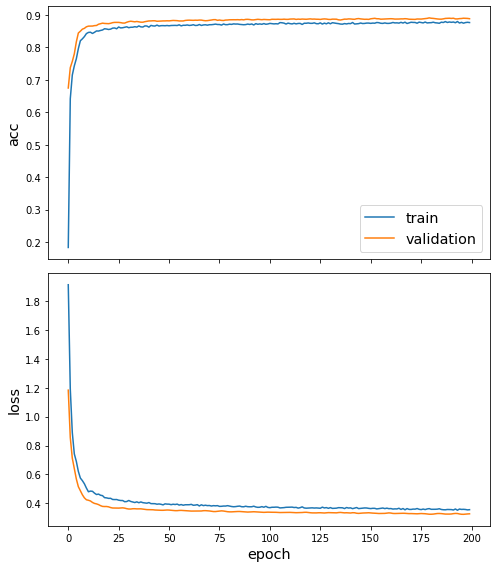

In [55]:
sg.utils.plot_history(history)

In [56]:
test_metrics = model.evaluate(test_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 1s 618ms/step - loss: 0.3257 - acc: 0.8882

Test Set Metrics:
	loss: 0.3257
	acc: 0.8882


In [57]:
y_pred = model.predict(test_gen)
y_pred = target_encoding.inverse_transform(y_pred.squeeze())
y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [58]:
y_test = target_encoding.inverse_transform(test_targets)
y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [59]:
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_gat_y_pred.pickle", "wb") as f:
  pickle.dump(y_pred, f)
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_gat_y_true.pickle", "wb") as f:
  pickle.dump(y_test, f)

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.98      0.99      0.98      3832
    Biologia       0.88      0.98      0.92      3522
      Chemia       0.78      0.42      0.55       416
      Fizyka       0.76      0.73      0.74       768
 Informatyka       0.78      0.75      0.77       738
  Matematyka       0.81      0.76      0.79      1211
 Psychologia       0.84      0.75      0.79       860

    accuracy                           0.89     11347
   macro avg       0.83      0.77      0.79     11347
weighted avg       0.88      0.89      0.88     11347



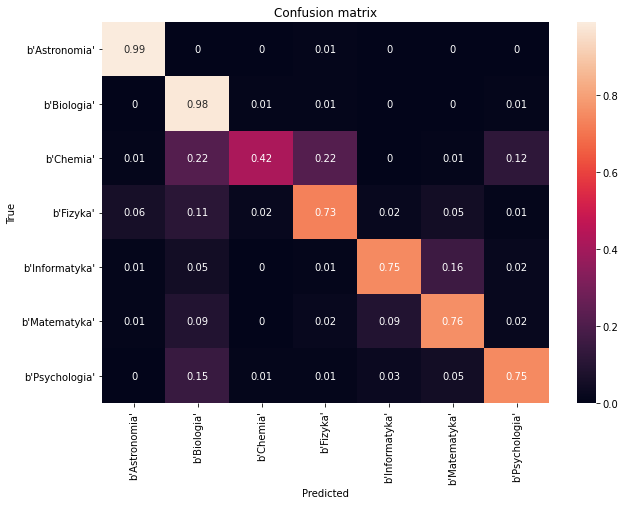

In [61]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)

### GCN

In [62]:
generator = FullBatchNodeGenerator(stellar_graph, method="gcn")

train_gen = generator.flow(train_subjects.index, train_targets)
test_gen = generator.flow(test_subjects.index, test_targets)
val_gen = generator.flow(val_subjects.index, val_targets)

Using GCN (local pooling) filters...


In [63]:
gcn = GCN(
    layer_sizes=[128, 128],
    activations=["elu", "elu"],
    generator=generator,
    dropout=0.5
)

In [64]:
x_inp, x_out = gcn.in_out_tensors()

dense = tf.keras.layers.Dense(units=64, activation="relu")(x_out)
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(dense)

In [65]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [66]:
# if not os.path.isdir("logs"):
#     os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
# mc_callback = ModelCheckpoint(
#     "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
# )

In [67]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback, mc_callback],
    # callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 1.9147 - acc: 0.1385 - val_loss: 1.7419 - val_acc: 0.6430
Epoch 2/200
1/1 - 0s - loss: 1.7471 - acc: 0.6175 - val_loss: 1.5414 - val_acc: 0.6545
Epoch 3/200
1/1 - 0s - loss: 1.5429 - acc: 0.6475 - val_loss: 1.3263 - val_acc: 0.6534
Epoch 4/200
1/1 - 0s - loss: 1.3213 - acc: 0.6502 - val_loss: 1.1316 - val_acc: 0.6519
Epoch 5/200
1/1 - 0s - loss: 1.1616 - acc: 0.6483 - val_loss: 0.9918 - val_acc: 0.6517
Epoch 6/200
1/1 - 0s - loss: 1.0108 - acc: 0.6480 - val_loss: 0.9083 - val_acc: 0.6582
Epoch 7/200
1/1 - 0s - loss: 0.9253 - acc: 0.6519 - val_loss: 0.8468 - val_acc: 0.6731
Epoch 8/200
1/1 - 0s - loss: 0.8670 - acc: 0.6704 - val_loss: 0.7902 - val_acc: 0.7113
Epoch 9/200
1/1 - 0s - loss: 0.8164 - acc: 0.7033 - val_loss: 0.7455 - val_acc: 0.7552
Epoch 10/200
1/1 - 0s - loss: 0.7724 - acc: 0.7399 - val_loss: 0.7180 - val_acc: 0.7763
Epoch 11/200
1/1 - 0s - loss: 0.7474 - acc: 0.7647 - val_loss: 0.7011 - val_acc: 0.7855
Epoch 12/200
1/1 - 0s - loss: 0.7331 - ac

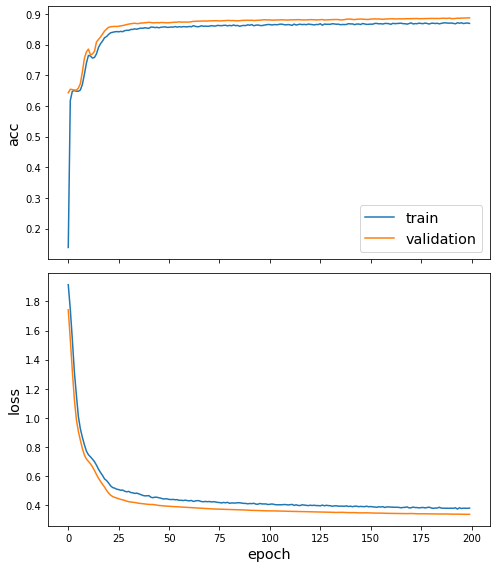

In [68]:
sg.utils.plot_history(history)

In [69]:
test_metrics = model.evaluate(test_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 65ms/step - loss: 0.3356 - acc: 0.8867

Test Set Metrics:
	loss: 0.3356
	acc: 0.8867


In [70]:
y_pred = model.predict(test_gen)
y_pred = target_encoding.inverse_transform(y_pred.squeeze())
y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [71]:
y_test = target_encoding.inverse_transform(test_targets)
y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Informatyka', 'Astronomia', 'Astronomia', 'Biologia',
       'Astronomia', 'Biologia', 'Astronomia', 'Matematyka', 'Biologia',
       'Biologia'], dtype='<U11')

In [72]:
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_gcn_y_pred.pickle", "wb") as f:
  pickle.dump(y_pred, f)
with open("/content/drive/Shareddrives/GCN-PROJECT/onehot140_gcn_y_true.pickle", "wb") as f:
  pickle.dump(y_test, f)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.99      0.99      0.99      3832
    Biologia       0.88      0.97      0.92      3522
      Chemia       0.67      0.60      0.63       416
      Fizyka       0.78      0.71      0.74       768
 Informatyka       0.76      0.76      0.76       738
  Matematyka       0.82      0.73      0.77      1211
 Psychologia       0.83      0.73      0.78       860

    accuracy                           0.89     11347
   macro avg       0.82      0.78      0.80     11347
weighted avg       0.88      0.89      0.88     11347



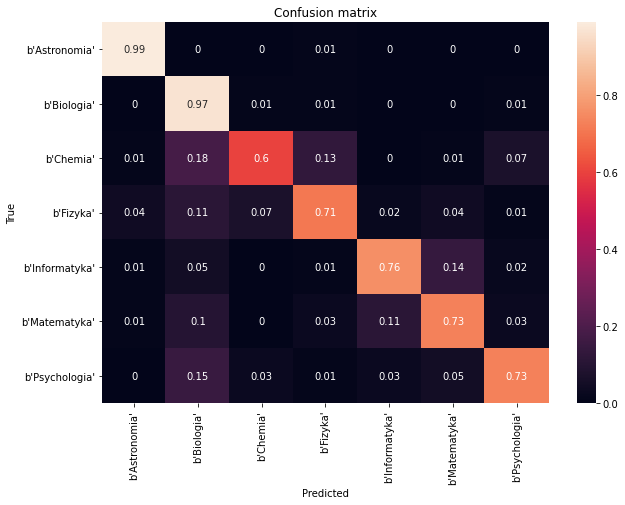

In [74]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)